# Explainable Random-Forest-Based Predictive Modelling Pipeline

**Dataset used in this notebook:** `Customer-Churn-Records.csv`

**Dataset Link:** 'https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn'

**Dataset Justification:** 'The Customer Churn dataset is chosen because it is practically relevant, interpretable, balanced for real-world complexity, and well-suited to demonstrate the entire explainable machine learning pipeline from preprocessing and feature construction to model evaluation and interpretability.'

In [18]:
# Phase 0 — Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.inspection import permutation_importance

# VIF imports
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

print('Setup complete.')


Setup complete.


In [19]:
# Simple loader
def load_csv(fname):
    df = pd.read_csv(fname)
    return df


In [20]:
# Phase 1 — Load dataset
df = load_csv("Customer-Churn-Records.csv")
print("Loaded dataset with shape:", df.shape)
df.head()


Loaded dataset with shape: (1000, 10)


,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,HasCrCard,IsActiveMember,Point Earned
0,15634602,Hargrave,619,Female,42,2,0.00,1,1,464
1,15647311,Hill,608,Female,41,1,83807.86,0,1,456
2,15619304,Onio,502,Female,42,8,159660.80,1,0,377
3,15701354,Boni,699,Female,39,1,0.00,0,0,350
4,15737888,Mitchell,850,Female,43,2,125510.82,1,1,425


In [21]:
# Quick column overview
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)


Columns: ['CustomerId', 'Surname', 'CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'Point Earned']

Data types:
 CustomerId          int64
Surname            object
CreditScore         int64
Gender             object
Age                 int64
Tenure              int64
Balance           float64
HasCrCard           int64
IsActiveMember      int64
Point Earned        int64
dtype: object


In [22]:
# Preprocessing pipeline: imputation, encoding, scaling
# Recompute column lists
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Robust target detection with fallback to last column
target_col = None

# 1) common exact names
possible_targets = ['Churn', 'churn', 'Exited', 'target', 'Target']
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break

# 2) substring search
if target_col is None:
    for c in df.columns:
        cl = str(c).lower()
        if 'churn' in cl or 'exited' in cl or 'is_churn' in cl:
            target_col = c
            break

# 3) binary-like columns
if target_col is None:
    for c in df.columns:
        if str(c).lower() in ('customerid', 'id'):
            continue
        nunique = df[c].dropna().nunique()
        if nunique == 2:
            vals = set(map(lambda v: str(v).strip().lower(), df[c].dropna().unique()))
            if vals <= {'0', '1'} or vals <= {'yes', 'no', 'y', 'n', 'true', 'false', 't', 'f'}:
                target_col = c
                break

# 4) fallback: last column
if target_col is None:
    target_col = df.columns[-1]
    print("Warning: target column not auto-detected. Falling back to last column:", target_col)
else:
    print("Detected target column:", target_col)

# Ensure target is excluded from features
numeric_features = [c for c in numeric_features if c != target_col]
categorical_features = [c for c in categorical_features if c != target_col]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

# Transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# OneHotEncoder compatibility (sparse_output vs sparse)
try:
    cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', cat_encoder)
])

# Build ColumnTransformer only with non-empty groups
transformers = []
if len(numeric_features) > 0:
    transformers.append(('num', numeric_transformer, numeric_features))
if len(categorical_features) > 0:
    transformers.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

print('Preprocessor prepared.')


Detected target column: HasCrCard
Numeric features: ['CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'IsActiveMember', 'Point Earned']
Categorical features: ['Surname', 'Gender']
Preprocessor prepared.


In [23]:
# Create simple derived features if present
if 'Tenure' in df.columns and 'MonthlyCharges' in df.columns:
    df['tenure_by_monthly'] = df['Tenure'] / (df['MonthlyCharges'] + 1e-6)
if 'TotalCharges' in df.columns and 'Tenure' in df.columns:
    df['avg_charge_per_month'] = df['TotalCharges'] / (df['Tenure'].replace(0, np.nan))
    df['avg_charge_per_month'] = df['avg_charge_per_month'].fillna(0)
# Recompute feature lists to include derived features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = [c for c in numeric_features if c != target_col]
categorical_features = [c for c in categorical_features if c != target_col]
print('Recomputed numeric and categorical features lengths:', len(numeric_features), len(categorical_features))


Recomputed numeric and categorical features lengths: 7 2


In [24]:
# Multicollinearity check (VIF) - optional and guarded
num_df = df.select_dtypes(include=[np.number]).dropna(axis=1, how='all')
num_df = num_df.drop(columns=[target_col]) if target_col in num_df.columns else num_df
if num_df.shape[1] >= 2 and num_df.shape[0] > 10 and num_df.shape[1] <= 50:
    X_vif = num_df.fillna(0)
    X_vif_const = sm.add_constant(X_vif)
    vif_data = []
    for i in range(X_vif.shape[1]):
        vif = variance_inflation_factor(X_vif_const.values, i+1)
        vif_data.append((X_vif.columns[i], vif))
    vif_df = pd.DataFrame(vif_data, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)
    display(vif_df.head(20))
else:
    print('Skipping VIF: either too few features, too many features (>50) or not enough rows.')


,feature,VIF
5,IsActiveMember,1.021024
2,Age,1.019306
3,Tenure,1.008445
1,CreditScore,1.007830
4,Balance,1.007665
0,CustomerId,1.005428
6,Point Earned,1.003260


In [25]:
# Rebuild preprocessor with current feature lists
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = [c for c in numeric_features if c != target_col]
categorical_features = [c for c in categorical_features if c != target_col]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

try:
    cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', cat_encoder)
])

transformers = []
if len(numeric_features) > 0:
    transformers.append(('num', numeric_transformer, numeric_features))
if len(categorical_features) > 0:
    transformers.append(('cat', categorical_transformer, categorical_features))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
print('Prepared preprocessor with', len(numeric_features), 'numeric and', len(categorical_features), 'categorical features.')


Prepared preprocessor with 7 numeric and 2 categorical features.


In [26]:
# Phase 2 — Model pipeline and parameter grid
rf = RandomForestClassifier(random_state=42)
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('clf', rf)])

param_grid = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [10, 20, None],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__min_samples_split': [2, 4],
    'clf__class_weight': ['balanced', None]
}
print('Pipeline and param grid ready.')


Pipeline and param grid ready.


In [27]:
# Split data and run GridSearchCV
X = df.drop(columns=[target_col])
y = df[target_col].copy()

# If target is textual (yes/no), map to 0/1
if y.dtype == 'object' or y.dtype.name == 'category':
    y = y.map(lambda v: 1 if str(v).strip().lower() in ['yes', 'y', '1', 'true', 't', 'churn', 'exited'] else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train/Test shapes:', X_train.shape, X_test.shape)

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=inner_cv, scoring='f1_macro', n_jobs=-1, verbose=2, refit=True)
grid.fit(X_train, y_train)

print('Grid search done. Best params:', grid.best_params_)


Train/Test shapes: (800, 9) (200, 9)
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Grid search done. Best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


In [29]:
# Present GridSearch results summary (safe version)
if 'grid' not in globals():
    print("GridSearchCV has not been run yet — please re-run the training cell first.")
else:
    if not hasattr(grid, "cv_results_"):
        print("GridSearchCV did not complete successfully. No results available.")
    else:
        results_df = pd.DataFrame(grid.cv_results_)
        cols = ['params', 'mean_test_score', 'std_test_score', 'mean_fit_time']
        display(results_df.sort_values('mean_test_score', ascending=False)[cols].head(10))


,params,mean_test_score,std_test_score,mean_fit_time
0,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.471004,0.020400,1.046973
1,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.469168,0.014245,2.397936
5,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.467995,0.031544,2.485726
4,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.465053,0.034613,1.148279
7,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.464875,0.026156,1.817611
6,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.463901,0.031373,0.906307
2,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.462625,0.024388,1.049341
12,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.461988,0.017527,1.059507
14,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.460222,0.016562,1.213018
3,"{'clf__class_weight': 'balanced', 'clf__max_de...",0.459710,0.026513,2.599288


Metrics on Train:
  Accuracy: 0.8725
  Precision: 0.8698
  Recall: 0.9626
  F1: 0.9139
  ROC_AUC: 0.9623
Metrics on Test:
  Accuracy: 0.6800
  Precision: 0.7104
  Recall: 0.9220
  F1: 0.8025
  ROC_AUC: 0.5546


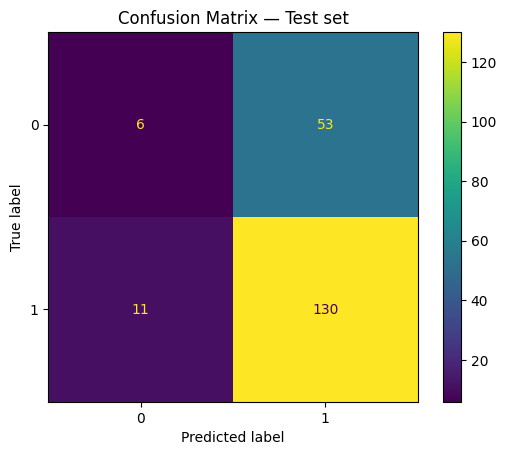

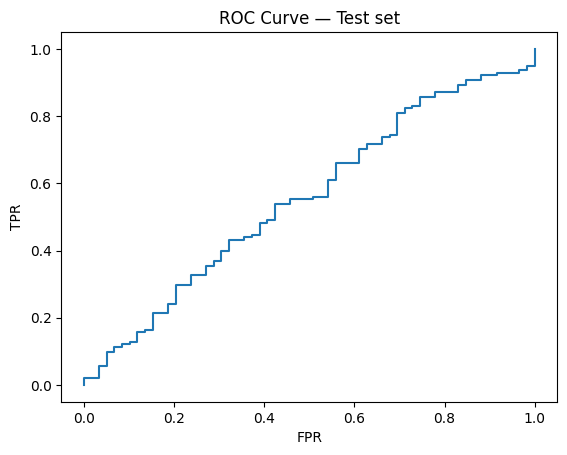

In [30]:
# Evaluate best model on train and test
best_model = grid.best_estimator_

def compute_metrics(model, X, y, set_name='set'):
    y_pred = model.predict(X)
    y_proba = None
    try:
        y_proba = model.predict_proba(X)[:,1]
    except:
        y_proba = None
    metrics = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0)
    }
    if y_proba is not None:
        try:
            metrics['ROC_AUC'] = roc_auc_score(y, y_proba)
        except:
            metrics['ROC_AUC'] = None
    print(f"Metrics on {set_name}:")
    for k,v in metrics.items():
        print(f"  {k}: {v:.4f}" if v is not None else f"  {k}: None")
    return metrics

train_metrics = compute_metrics(best_model, X_train, y_train, set_name='Train')
test_metrics = compute_metrics(best_model, X_test, y_test, set_name='Test')

# Confusion matrix
y_test_pred = best_model.predict(X_test)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred))
disp.plot()
plt.title('Confusion Matrix — Test set')
plt.show()

# ROC curve if available
if hasattr(best_model, 'predict_proba'):
    try:
        y_test_proba = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curve — Test set')
        plt.show()
    except Exception as e:
        print('ROC plot skipped:', e)


In [31]:
# Explainability: robust permutation-importance -> feature name alignment (REPLACE the old cell with this)
from sklearn.inspection import permutation_importance

# Safety checks: ensure training ran
required_vars = ['X_test', 'y_test', 'best_model']
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Missing variables {missing}. Run train-test split and model training first.")

# Sample subset for speed
sample_X = X_test.sample(n=min(200, len(X_test)), random_state=42)
sample_y = y_test.loc[sample_X.index]

# Compute permutation importances
r = permutation_importance(best_model, sample_X, sample_y, n_repeats=10, random_state=42, n_jobs=-1)

# Helper: robust feature name extraction for ColumnTransformer + OneHotEncoder across sklearn versions
def get_preprocessor_feature_names(preprocessor, numeric_features, categorical_features):
    # 1) try direct get_feature_names_out (sklearn >=1.0)
    try:
        names = list(preprocessor.get_feature_names_out())
        return names
    except Exception:
        pass

    # 2) build names manually from transformers_
    feature_names = []
    try:
        for name, trans, cols in preprocessor.transformers_:
            if name == 'remainder':
                continue
            # if transformer is None or 'passthrough'
            if trans is None or (isinstance(trans, str) and trans == 'passthrough'):
                feature_names.extend(list(cols))
                continue
            # if pipeline, take last step
            if hasattr(trans, 'named_steps'):
                last = list(trans.named_steps.values())[-1]
            else:
                last = trans
            # if onehot-like
            if hasattr(last, 'get_feature_names_out'):
                try:
                    names = list(last.get_feature_names_out(cols))
                except Exception:
                    # sometimes OneHotEncoder.get_feature_names_out expects no args
                    names = list(last.get_feature_names_out())
                feature_names.extend(names)
            else:
                # fallback: add original column names
                feature_names.extend(list(cols))
    except Exception:
        # worst-case fallback: combine original lists
        feature_names = list(numeric_features) + list(categorical_features)
    return feature_names

# Compute feature names using best_model's preprocessor if possible
try:
    preproc = best_model.named_steps['preprocessor']
    feat_names = get_preprocessor_feature_names(preproc, numeric_features, categorical_features)
except Exception as e:
    print("Warning while getting feature names:", e)
    feat_names = list(numeric_features) + list(categorical_features)

# Diagnostics
print("len(feature names) =", len(feat_names))
print("len(importances)    =", len(r.importances_mean))

# Align lengths: trim or pad with placeholders so DataFrame creation won't fail
if len(feat_names) != len(r.importances_mean):
    if len(feat_names) > len(r.importances_mean):
        print("Note: feature-name list is longer than importances. Trimming feature names.")
        feat_names = feat_names[:len(r.importances_mean)]
    else:
        print("Note: importances longer than feature-name list. Adding placeholder names.")
        missing = len(r.importances_mean) - len(feat_names)
        placeholders = [f"feature_{i}" for i in range(len(feat_names), len(feat_names) + missing)]
        feat_names = feat_names + placeholders

# Build and display DataFrame
imp_df = pd.DataFrame({'feature': feat_names, 'importance_mean': r.importances_mean})
imp_df = imp_df.sort_values('importance_mean', ascending=False).reset_index(drop=True)
display(imp_df.head(30))


len(feature names) = 626
len(importances)    = 9
Note: feature-name list is longer than importances. Trimming feature names.


,feature,importance_mean
0,num__CustomerId,3.400000e-02
1,num__IsActiveMember,1.900000e-02
2,num__Balance,1.850000e-02
3,cat__Surname_Ahmed,9.500000e-03
4,cat__Surname_Abbie,6.000000e-03
5,num__Age,4.500000e-03
6,num__Tenure,2.220446e-17
7,num__Point Earned,-5.000000e-04
8,num__CreditScore,-2.000000e-03


In [32]:
# Robustness check: flip 10% of labels in training set, retrain with best params, evaluate
def add_label_noise(y, noise_frac=0.1, random_state=42):
    y_noisy = y.copy().reset_index(drop=True)
    n = len(y_noisy)
    rng = np.random.RandomState(random_state)
    idx = rng.choice(n, size=int(noise_frac * n), replace=False)
    y_noisy.iloc[idx] = 1 - y_noisy.iloc[idx]
    return y_noisy

y_train_noisy = add_label_noise(y_train, noise_frac=0.1, random_state=42)
# Refit a new pipeline with the best parameters found
best_params = grid.best_params_
# create a fresh estimator with same params
rf2 = RandomForestClassifier(random_state=42,
                             n_estimators=best_params.get('clf__n_estimators', 200),
                             max_depth=best_params.get('clf__max_depth', None),
                             max_features=best_params.get('clf__max_features', 'sqrt'),
                             min_samples_split=best_params.get('clf__min_samples_split', 2),
                             class_weight=best_params.get('clf__class_weight', None))
pipe_noisy = Pipeline(steps=[('preprocessor', preprocessor), ('clf', rf2)])
pipe_noisy.fit(X_train, y_train_noisy)

print('Metrics on test set after training on noisy labels:')
compute_metrics(pipe_noisy, X_test, y_test, set_name='Test (noisy-train)')


Metrics on test set after training on noisy labels:
Metrics on Test (noisy-train):
  Accuracy: 0.6650
  Precision: 0.7284
  Recall: 0.8369
  F1: 0.7789
  ROC_AUC: 0.5328


{'Accuracy': 0.665,
 'Precision': 0.7283950617283951,
 'Recall': 0.8368794326241135,
 'F1': 0.7788778877887789,
 'ROC_AUC': 0.532756340906359}